In [139]:
'''
Before running this notebook - install this package
(i.e., in the terminal, inside this folder run:
"pip install -e .")
Also make sure that prfpy is installed
& that you are running the correct kernel

If you have your own data, I would reccomend loading in 100 voxels first. Visually inspect them to check for the kind of bumps that display visual responses. Then run the analysis to check that everything is working.
For full brain data, you will probably want to run on a cluster if it is available.  
'''

'\nBefore running this notebook - install this package\n(i.e., in the terminal, inside this folder run:\n"pip install -e .")\nAlso make sure that prfpy is installed\n& that you are running the correct kernel\n\nIf you have your own data, I would reccomend loading in 100 voxels first. Visually inspect them to check for the kind of bumps that display visual responses. Then run the analysis to check that everything is working.\nFor full brain data, you will probably want to run on a cluster if it is available.  \n'

In [140]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, Norm_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, Norm_Iso2DGaussianFitter
import os

from marcus_prf_eg.utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This notebook shows a simple example of prfpy use, fitting a Gaussian model

# Creating stimulus object
Before fitting the PRFs we need to create the design matrix, i.e., a binary representation of the stimulus. The stimuli used in this example is a bar moving across the visual field (see eg_screen_shot.png for an example). 

prfpy needs the design matrix to be a numpy array of n x n x time points. Each time point will correspond to the timepoints in the fMRI sequence. n is the number of pixels in the design matrix. 

Going from the stimulus shown in the scanner to the n x n x timepoints in the design matrix involves 3 steps:

[1] Binarize the stimulus (where there is stimulus=1, no stimulus=0)

[2] Make it square (i.e., cut off the unstimulated part of the screen). This is because typically the stimuli are presented in a circular aperture; therefore including the full rectangle of the screen is unnecessary. 

[3] Downsample the stimulus (so that it can run faster, e.g., from 1080 x 1080 to 100 x 100)

If you want you could also just recreate the design matrix from same parameters you used to make the stimulus (i.e., defining bar/wedge position over time). This doesn't matter

In [141]:
# We can use a function from Jurjen to do this... This may take a couple of minutes
dm_from_screenshots = get_prfdesign(
    screenshot_path='./screen_shots',   # Path to the screenshots, 1 per TR
    n_pix = 100,                        # How many pixels do we want in the design matrix? (fewer means faster, default is 100 x 100)
    dm_edges_clipping = [0,0,0,0],      # Do we want to clip any of the edges of the design matrix? Default is no...
)

UFuncTypeError: Cannot cast ufunc 'true_divide' input 0 from dtype('O') to dtype('float32') with casting rule 'same_kind'

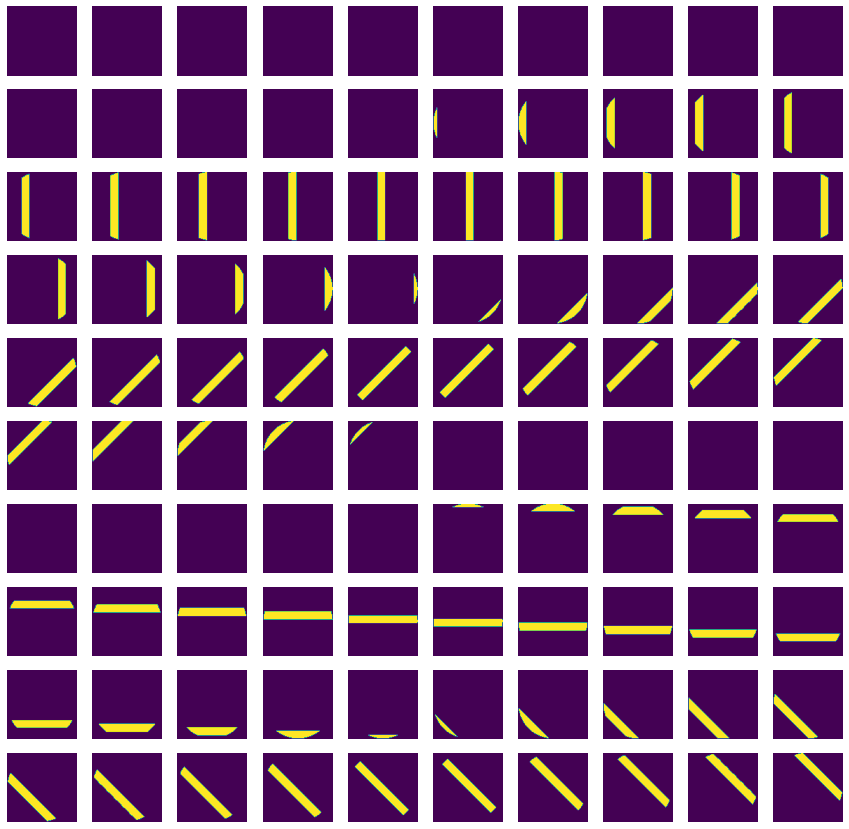

In [ ]:
# If you already have the design matrix as a numpy array, you can simply load it...
dm = np.load('./design_matrix.npy')

# You can see we have a binarized matrix, of a bar moving across the screen...
fig = plt.figure()
rows = 10
cols = 10
fig.set_size_inches(15,15)
for i in range(100):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(dm[:,:,i], vmin=0, vmax=1)
    ax.axis('off')


In [ ]:
# Now we need to enter the design matrix in a way that prfpy can read it. 
# We do this using the PRFStimulus2D object
# Information we need
# -> Screen size (height), and distance (to the eye)
# This is so that we can convert into degrees of visual angle (dov)
# -> TR: This is so that we know the time (in s), of each 'frame' / pt in the time series
# Here we have 225 time points. So total length of scan was TR * 225 (1.5*225) 
prf_stim = PRFStimulus2D(
    screen_size_cm=39.3,         # Distance of screen to eye
    screen_distance_cm=196,    # height of the screen (i.e., the diameter of the stimulated region)
    design_matrix=dm,           # dm (npix x npix x time_points)
    TR=1.5,                     # TR
    )
print(f'Screen size in degrees of visual angle = {prf_stim.screen_size_degrees}')

# If for some reason you do not have the original dimensions, but you do have the dov, you can use this calculator:
# https://elvers.us/perception/visualAngle/ to make up some values for screen_size and distance, which will work...


Screen size in degrees of visual angle = 11.450128652841203


# Preparing the data
The next step is to prepare the fMRI time series. The format that prfpy wants is a numpy array of number of 
For prfpy the time series needs to be 2D numpy array, where the first dimension is units (i.e., voxels or vertices) and the second dimension is time. The number of timepoints in your data should match the number in the design matrix (here it is 225). 

A couple of notes:

[*] Preprocessing? I assume that all of the important stuff, i.e., denoising, removing confounds has been done already. This is just to prepare the data for prfpy specifically. 

[*] Averaging? The more runs (i.e., repetitions of the same stimulus) you average over, the less noise, and the better the prf estimates will be. You can fit on a single run (especially in high SNR situations, e.g., using 7T) without averaging, but quality will be less good. 

[*] Voxels or vertices? In principle you can fit any time series data with a prf model. I always fit using vertices, with the data sampled to the cortical surface. This will make visualisations much easier, if you want to plot your PRF parameters on the cortical surface. You can then use tools like pycortex

[*] Percent signal change? Again, in principle you can fit any time series data with a prf model. I use percent signal change, with the baseline set to 0. Why do this? It makes it easier to compare timeseries across voxels when the units are the same (as opposed to the arbitrary values you get out of "raw" fMRI data). Also, if you do *not* set the baseline value to 0 (i.e. the amplitude of the prf model when there is 0 stimulation) you need to fit it for each vertex. There are also added complications when you have PRFs with inhibitory components. Another option is to use z-scoring rather than psc. 

[*] Include first part of timeseries? Some people will remove the first (e.g.,5) timepoints of the fMRI data. This is because perhaps it takes a couple of seconds for the subject to get used to the scanner / stimulus or maybe there are startup effects... If you want to do this, make sure you make the corresponding changes to the design matrix.  

### Steps, using example data
I have provided some example time series data for 100 vertices

[1] Convert to percent signal change

[2] Set the median value during the baseline condition (i.e., when there is no stimulation) to zero

See functions in marcus_prf_eg/utils for more details



Example, raw time series. You can already see the peaks corresponding to the bar passes. 
But the units are arbitrary... We want to change it to be in psc
Also we can improve the SNR by averaging over the 2 runs...



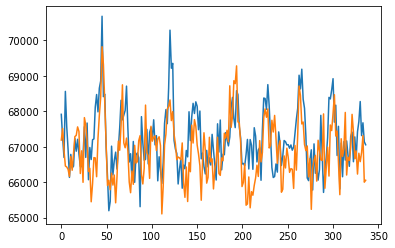

In [ ]:
run1 = np.load('ts_run_1.npy') # Load the example data
run2 = np.load('ts_run_2.npy') # Diferent runs...

TR_s = 1.5
time_pts = np.arange(run1.shape[1]) * TR_s
i_vx = 99
plt.plot(time_pts, run1[i_vx,:])
plt.plot(time_pts, run2[i_vx,:])
print('''
Example, raw time series. You can already see the peaks corresponding to the bar passes. 
But the units are arbitrary... We want to change it to be in psc
Also we can improve the SNR by averaging over the 2 runs...
''')


Now we can see what the the time series looks like after psc, baselining and averaging:



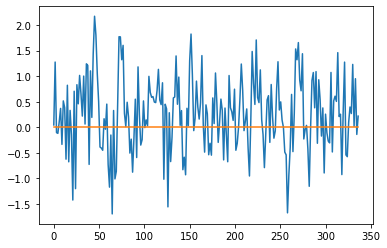

In [ ]:
# Do the averaging and baselining...
# During the first 20 time points, there is NO stimulation. So we use this to set the baseline
psc_avg_ts = raw_ts_to_average_psc(
    raw_ts=[run1, run2],        # Enter the runs as a list of np.ndarrays
    baseline=20                 # The first 20 time points, there is NO stimulation. So we use this to set the baseline
)

print('''
Now we can see what the the time series looks like after psc, baselining and averaging:
''')
i_vx = 20

plt.plot(time_pts, psc_avg_ts[i_vx,:])
plt.plot(time_pts, time_pts*0)

# Creating the (gaussian) model
Now we can create the PRF model. The simplest is the 2D isometric (i.e., circular) gaussian
For simplicity we will set up the model, using the default settings


In [ ]:
'''
The Iso2DGaussianModel class is used to create an 2D gaussian model instance.
There are a few parameters you can set. See below (copied from prfpy documentation), for details.
Note you can also fit the HRF, but for simplicity this is no covered here
    
        """__init__ for Iso2DGaussianModel
        constructor, sets up stimulus and hrf for this Model
        Parameters
        ----------
        stimulus : PRFStimulus2D
            Stimulus object specifying the information about the stimulus,
            and the space in which it lives.
        hrf : string, list or numpy.ndarray, optional
            HRF shape for this Model.
            Can be 'direct', which implements nothing (for eCoG or later convolution),
            a list or array of 3, which are multiplied with the three spm HRF basis functions,
            and an array already sampled on the TR by the user.
            (the default is None, which implements standard spm HRF)
        filter_predictions : boolean, optional
            whether to high-pass filter the predictions, default False
        filter_type, filter_params : see timecourse.py
        normalize_RFs : whether or not to normalize the RF volumes (generally not needed).
'''
gg = Iso2DGaussianModel(
    stimulus=prf_stim, # The stimulus we made earlier
    hrf=[1,1,0],       # These are the parameters for the HRF that we normally use at Spinoza (with 7T data)
    )

/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy/prfpy/model.py:247: FutureWarning: Specifying HRF parameters is deprecated. Please refer to the HRF class and specify an HRF object.
  warnings.warn(


# Creating the gaussian fitter
Now we need to make a fitter, to load in the data


In [ ]:
gf = Iso2DGaussianFitter(
    data=psc_avg_ts,    # time series
    model=gg,           # model (see above)
    n_jobs=1,           # number of jobs to use in parallelization 
    fit_hrf=False       # Do or do not fit the hrf (not doing that here)
    )

## Gaussian grid fit

In [ ]:
print('''
The first stage is the 'grid fit'
Here we make a "grid" of possible PRF models, (different locations: polar angle, eccentricity, as well as sizes)
''')
max_eccentricity = prf_stim.screen_size_degrees/2 # It doesn't make sense to look for PRFs which are outside the stimulated region
grid_nr = 30 # Size of the grid (i.e., number of possible PRF models). Higher number means that the grid fit will be more exact, but take longer...
eccs    = max_eccentricity * np.linspace(0.25, 1, grid_nr)**2 # Squared because of cortical magnification, more efficiently tiles the visual field...
sizes   = max_eccentricity * np.linspace(0.1, 1, grid_nr)**2  # Possible size values (i.e., sigma in gaussian model) 
polars  = np.linspace(0, 2*np.pi, grid_nr)              # Possible polar angle coordinates

print('''
We also want to put some boundaries on possible values
We set the baseline to 0, so we want to fix that here. 'fixed_grid_baseline=0'
In addition, there is the amplitude parameter (which scales the response). 
We want to put an upper limit for this too, so that we don't get strange responses
''')

gauss_grid_bounds = [[0,1000]] # Amplitude - set [min, max]

gf.grid_fit(
    ecc_grid=eccs,
    polar_grid=polars,
    size_grid=sizes,
    verbose=True,
    n_batches=10,               # The grid fit is performed in parallel over n_batches of units.Batch parallelization is faster than single-unit parallelization and of sequential computing.
    fixed_grid_baseline=0,
    grid_bounds=gauss_grid_bounds)


The first stage is the 'grid fit'
Here we make a "grid" of possible PRF models, (different locations: polar angle, eccentricity, as well as sizes)


We also want to put some boundaries on possible values
We set the baseline to 0, so we want to fix that here. 'fixed_grid_baseline=0'
In addition, there is the amplitude parameter (which scales the response). 
We want to put an upper limit for this too, so that we don't get strange responses

Each batch contains approx. 10 voxels.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.0s finished


## Gaussian Iterative Fit
Now we can do the iterative fit. This takes the best fitting grid (from the above stage), and iteratively tweaks the parameters until the best fit is founds. 
This takes a bit longer than the grid fit. We also need to setup the bounds for all the parameters. 

In [154]:
gauss_bounds = [(-1.5*max_eccentricity, 1.5*max_eccentricity),  # x bound
                (-1.5*max_eccentricity, 1.5*max_eccentricity),  # y bound
                (1e-1, max_eccentricity*3),  # prf size bounds
                (-10, 1000),  # prf amplitude
                (0, 0)]     # bold baseline (fixed)
gf.iterative_fit(
    rsq_threshold=0.1,          # Minimum variance explained. Puts a lower bound on the quality of PRF fits. Any fits worse than this are thrown away...     
    verbose=False,
    bounds=gauss_bounds,
    constraints=None,             # We can introduce constraints... this is more relevant for later. It also controls what fitter is used (lgbfs, vs tc). See prfpy documentation for more details
    xtol=0.000001,               # float, passed to fitting routine numerical tolerance on x
    ftol=0.000001,               # float, passed to fitting routine numerical tolerance on function
    )               
# Xtol and Ftol determine when the fitter stops trying to improve the fit. Set to higher values to to terminate sooner and speed up the fitting


/home/daghlian/.conda/envs/ls_clone/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


# WELL DONE!
We now have a set of prf fits. 


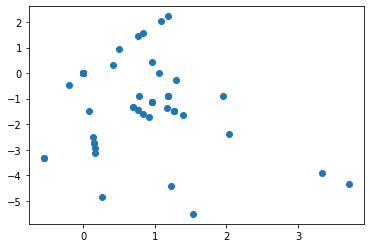

In [156]:
# The parameters are stored as a np.ndarray with units x parameters
# gf.iterative_search_params[:,0] -> x position of prf
# gf.iterative_search_params[:,1] -> y position of prf
# gf.iterative_search_params[:,2] -> size of prf
# gf.iterative_search_params[:,3] -> amplitude of prf
# gf.iterative_search_params[:,4] -> baseline of prf
# gf.iterative_search_params[:,5] -> rsq of prf

# Plot the location...
plt.scatter(gf.iterative_search_params[:,0], gf.iterative_search_params[:,1])
